In [ ]:
# This creates odds and ownership df for projections. Maybe seaparate

In [1]:
import os
import numpy as np
import pandas as pd
import requests
baseball_path = r"C:\Users\james\Documents\MLB\Data"

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# This reads in a map of team name, codes, and the number Fangraphs uses in their URLs
team_map = pd.read_csv(os.path.join(baseball_path, "Utilities", "Team Map.csv"))

# We just need teams right now
team_map = team_map[['FULLNAME', 'ROTOWIRETEAM', 'BBREFTEAM']]

In [4]:
# Has a lot more fun data too! Including, weirdly, team colors! Might want to add more to this later
def gamble_df(jsonData):
    list_list = []
    for i in range(len(jsonData)):
        home_name = jsonData[i]['EventDetails']['Properties']['HomeTeamShort']
        away_name = jsonData[i]['EventDetails']['Properties']['VisitorTeamShort']
        home_runs = jsonData[i]['EventDetails']['Properties']['HomeVegasRuns']
        away_runs = jsonData[i]['EventDetails']['Properties']['VisitorVegasRuns']

        home_ml = jsonData[i]['EventDetails']['Properties']['HomeGameMoneylineCurrent']

        home_ou = jsonData[i]['EventDetails']['Properties']['HomeGameOUCurrent']
        home_ou_juice = jsonData[i]['EventDetails']['Properties']['HomeGameOUJuiceCurrent']

        home_spread = jsonData[i]['EventDetails']['Properties']['HomeGameSpreadCurrent']
        home_spread_juice = jsonData[i]['EventDetails']['Properties']['HomeGameSpreadJuiceCurrent']

        date = jsonData[i]['EventDetails']['Properties']['EventDateId']

        gamble_list = [away_name, away_runs, home_name, home_runs, home_ou, home_ou_juice, home_spread, home_spread_juice, home_ml, date]
        list_list.append(gamble_list)
    
    df = pd.DataFrame(list_list, columns=['away_team','away_runs', 'home_team', 'home_runs', 'ou', 'ou_juice', 'spread', 'spread_juice', 'ml', 'date'])
    
    return df

In [132]:
# # Create all odds DFs
# import time
# for filename in os.listdir(r"C:\Users\james\Documents\MLB\Data\Rosters\Depth"):
#     date = filename[5:13]
#     print(date)
    
#     dateStr = date[0:4] + "-" + date[4:6] + "-" + date[6:8]
    
#     url = f'https://www.fantasylabs.com/api/sportevents/3/{dateStr}/vegas/?sportId=3&date={dateStr}'
#     headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36'}
#     jsonData = requests.get(url, headers=headers).json()
    
#     try:
#         df = gamble_df(jsonData)
#         odds_filename = "Odds " + date + ".csv"
#         df.to_csv(os.path.join(baseball_path, "Odds", odds_filename))
#         time.sleep(6)
        
#     except:
#         pass

20220401
20220402
20220403
20220404
20220405
20220406
20220407
20220408
20220409
20220410
20220411
20220412
20220413
20220414
20220415
20220416
20220417
20220418
20220419
20220420
20220421
20220422
20220423
20220424
20220425
20220426
20220427
20220428
20220429
20220430
20220501
20220502
20220503
20220504
20220505
20220506
20220507
20220508
20220509
20220510
20220511
20220512
20220513
20220514
20220515
20220516
20220517
20220518
20220519
20220520
20220521
20220522
20220523
20220524
20220525
20220526
20220527
20220528
20220529
20220530
20220531
20220601
20220602
20220603
20220604
20220605
20220606
20220607
20220608
20220609
20220610
20220611
20220612
20220613
20220614
20220615
20220616
20220617
20220618
20220619
20220620
20220621
20220622
20220623
20220624
20220625
20220626
20220627
20220628
20220629
20220630
20220701
20220702
20220703
20220704
20220705
20220706
20220707
20220708
20220709
20220710
20220711
20220712
20220713
20220714
20220715
20220716
20220717
20220718
20220719
20220720
2

In [45]:
def daily_ownership(date):
    # Read in salaries
    salaries_name = "DKSalaries_" + date + ".csv"
    salaries = pd.read_csv(os.path.join(baseball_path, "Salaries Scraped", salaries_name))
    
    salaries = salaries[['Position', 'Name', 'Roster Position', 'Game Info', 'TeamAbbrev', 'Salary']]
    
    # Read in results (for ownership)
    results_name = "Results " + date + ".csv"
    results = pd.read_csv(os.path.join(baseball_path, "Results Scraped", results_name))
    
    results = results[['Player', '%Drafted', 'FPTS']]
    
    df = salaries.merge(results, left_on='Name', right_on='Player', how='left')
    
    # Read in gambling ondds 
    odds_name = "Odds " + date + ".csv"
    odds = pd.read_csv(os.path.join(baseball_path, "Odds", odds_name))    
    
    odds = odds.merge(team_map, left_on='away_team', right_on='ROTOWIRETEAM', how='inner', suffixes=("", "away"))
    odds = odds.merge(team_map, left_on='home_team', right_on='ROTOWIRETEAM', how='inner', suffixes=("", "home"))
    
    odds['Game Info'] = odds['BBREFTEAM'] + "@" + odds['BBREFTEAMhome']
    
    # Just want runs for now
    odds = odds[['Game Info', 'away_runs', 'home_runs', 'BBREFTEAMhome']]
    
    df = df.merge(odds, on='Game Info', how='inner')
    
    # Slate size
    num_matchups = len(df['Game Info'].unique())
    df['num_matchups'] = num_matchups
    
    # Pitcher dummy
    df['pitcher'] = df['Roster Position'].isin(['SP', 'RP']).astype('int')
    
    # Runs scored/allowed
    df['rs'] = np.where(df['TeamAbbrev'] == df['BBREFTEAMhome'], df['home_runs'], df['away_runs'])
    df['ra'] = np.where(df['TeamAbbrev'] == df['BBREFTEAMhome'], df['away_runs'], df['home_runs'])
        
   # Rank among teams
    team_runs = df.drop_duplicates(subset='TeamAbbrev')[['TeamAbbrev', 'rs', 'ra']]
    team_runs['rs_rank'] = team_runs['rs'].rank()
    team_runs['ra_rank'] = team_runs['ra'].rank()
    team_runs = team_runs[['TeamAbbrev', 'rs_rank', 'ra_rank']]

    df = df.merge(team_runs, on='TeamAbbrev', how='inner')
    
    df['P'] = df['Roster Position'].isin(['SP', 'RP']).astype('int')
    df['1B'] = df['Roster Position'].str.contains('1B').astype('int')
    df['2B'] = df['Roster Position'].str.contains('2B').astype('int')
    df['3B'] = df['Roster Position'].str.contains('3B').astype('int')
    df['SS'] = df['Roster Position'].str.contains('SS').astype('int')
    df['C'] = df['Roster Position'].str.contains('C').astype('int')
    df['OF'] = df['Roster Position'].str.contains('OF').astype('int')
    
    df['num_pos'] = df[['P', '1B', '2B', '3B', 'SS', 'C', 'OF']].sum(axis=1)
    
    # Rank salary by position
    # df['Salary_rank'] = df.groupby(['Position'])['Salary'].rank()

    df['date'] = date
    
    return df

df = daily_ownership("20220407")
df

,Position,Name,Roster Position,Game Info,TeamAbbrev,Salary,Player,%Drafted,FPTS,away_runs,...,P,1B,2B,3B,SS,C,OF,num_pos,Salary_rank,date
0,SP,Max Fried,SP,CIN@ATL,ATL,9000,Max Fried,30.56,6.76,3.7,...,1,0,0,0,0,0,0,1,8.0,20220407
1,RF,Ronald Acuna Jr.,OF,CIN@ATL,ATL,6000,Ronald Acuna Jr.,0.02,0.00,3.7,...,0,0,0,0,0,0,1,1,20.0,20220407
2,1B,Matt Olson,1B,CIN@ATL,ATL,5700,Matt Olson,11.94,6.00,3.7,...,0,1,0,0,0,0,0,1,21.0,20220407
3,2B,Ozzie Albies,2B,CIN@ATL,ATL,5500,Ozzie Albies,12.70,3.00,3.7,...,0,0,1,0,0,0,0,1,15.0,20220407
4,3B,Austin Riley,3B,CIN@ATL,ATL,5400,Austin Riley,8.18,22.00,3.7,...,0,0,0,1,0,0,0,1,17.5,20220407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,CF,Corey Dickerson,OF,PIT@STL,STL,3200,Corey Dickerson,0.07,0.00,3.7,...,0,0,0,0,0,0,1,1,12.0,20220407
175,3B,Brendan Donovan,3B,PIT@STL,STL,2100,Brendan Donovan,0.00,0.00,3.7,...,0,0,0,1,0,0,0,1,7.0,20220407
176,3B,Nolan Gorman,2B,PIT@STL,STL,2000,Nolan Gorman,0.01,0.00,3.7,...,0,0,1,0,0,0,0,1,3.0,20220407
177,1B,Juan Yepez,OF,PIT@STL,STL,2000,Juan Yepez,0.00,0.00,3.7,...,0,0,0,0,0,0,1,1,2.0,20220407


In [412]:
df = daily_ownership("20221005")
df.query('Name == "Spenser Watkins"')

,Position,Name,Roster Position,Game Info,TeamAbbrev,Salary,Player,%Drafted,FPTS,away_runs,...,P,1B,2B,3B,SS,C,OF,num_pos,Salary_rank,date
525,RP,Spenser Watkins,SP,TOR@BAL,BAL,6200,Spenser Watkins,0.0,0.0,3.2,...,1,0,0,0,0,0,0,1,7.5,20221005
526,RP,Spenser Watkins,SP,TOR@BAL,BAL,6200,Spenser Watkins,0.0,0.0,3.3,...,1,0,0,0,0,0,0,1,7.5,20221005


In [317]:
df_list = []
for filename in os.listdir(r"C:\Users\james\Documents\MLB\Data\Rosters\Depth"):
    date = filename[5:13]
    print(date)
    
    try:
        df = daily_ownership(date)
        df_list.append(df)
    except:
        pass
    
ownership_df = pd.concat(df_list, axis=0)

20220401
20220402
20220403
20220404
20220405
20220406
20220407
20220408
20220409
20220410
20220411
20220412
20220413
20220414
20220415
20220416
20220417
20220418
20220419
20220420
20220421
20220422
20220423
20220424
20220425
20220426
20220427
20220428
20220429
20220430
20220501
20220502
20220503
20220504
20220505
20220506
20220507
20220508
20220509
20220510
20220511
20220512
20220513
20220514
20220515
20220516
20220517
20220518
20220519
20220520
20220521
20220522
20220523
20220524
20220525
20220526
20220527
20220528
20220529
20220530
20220531
20220601
20220602
20220603
20220604
20220605
20220606
20220607
20220608
20220609
20220610
20220611
20220612
20220613
20220614
20220615
20220616
20220617
20220618
20220619
20220620
20220621
20220622
20220623
20220624
20220625
20220626
20220627
20220628
20220629
20220630
20220701
20220702
20220703
20220704
20220705
20220706
20220707
20220708
20220709
20220710
20220711
20220712
20220713
20220714
20220715
20220716
20220717
20220718
20220719
20220720
2

In [324]:
ownership_df_copy = ownership_df.copy()

In [86]:
df_list = []
for filename in os.listdir(r"C:\Users\james\Documents\MLB\Data\New_Matchups"):
    date = filename[8:16]
    
    matchup_path = os.path.join(baseball_path, "New_Matchups", "Matchups"+date)

    for filename in os.listdir(matchup_path):
        date_df_list = []
        f = os.path.join(matchup_path, filename)       
        # checking if it is a file
        if os.path.isfile(f):
            away_batters = pd.read_excel(f, sheet_name='AwayBatters')
            away_pitchers = pd.read_excel(f, sheet_name='AwayPitchers')
            home_batters = pd.read_excel(f, sheet_name='HomeBatters')
            home_pitchers = pd.read_excel(f, sheet_name='HomePitchers')
            
            away_pitchers['starter_hand'] = away_pitchers['starter'] * away_pitchers['p_L']
            away_pitcher_l = away_pitchers['starter_hand'].sum()
            
            home_pitchers['starter_hand'] = home_pitchers['starter'] * home_pitchers['p_L']
            home_pitcher_l = home_pitchers['starter_hand'].sum()
            
            away_batters['starter_hand'] = home_pitcher_l
            home_batters['starter_hand'] = away_pitcher_l
            
            date_df_list.append(away_batters)
            date_df_list.append(away_pitchers)
            date_df_list.append(home_batters)
            date_df_list.append(home_pitchers)
        
        date_df = pd.concat(date_df_list,axis=0)
        date_df = date_df[['Name', 'batting_order', 'Leverage', 'woba_l', 'woba_r', 'obp_l', 'obp_r', 'slg_l', 'slg_r', 'batSide', 'starter_hand']]
        date_df['b_L'] = (date_df['batSide'] == "L").astype('int')
        
        date_df['adv'] = (date_df['b_L'] != date_df['starter_hand']).astype('int')
        
        date_df['date'] = date
        df_list.append(date_df)
        
df = pd.concat(df_list, axis=0)
df.head()
            

,Name,batting_order,Leverage,woba_l,woba_r,obp_l,obp_r,slg_l,slg_r,batSide,starter_hand,b_L,adv,date
0,Aramis Garcia,NaN,0,0.294157,0.269938,0.273272,0.253730,0.377113,0.344765,R,1,0,1,20220407
1,Aristides Aquino,2.0,0,0.342864,0.320786,0.319744,0.289111,0.415337,0.413582,R,1,0,1,20220407
2,Brandon Drury,9.0,0,0.332785,0.304366,0.308798,0.285776,0.428055,0.389900,R,1,0,1,20220407
3,Colin Moran,NaN,0,0.273286,0.340161,0.273560,0.325196,0.317856,0.414391,L,1,1,0,20220407
4,Jake Fraley,NaN,0,0.282631,0.350834,0.292336,0.337670,0.302170,0.411613,L,1,1,0,20220407


In [95]:
df['batting_order'].fillna(0,inplace=True)
df2 = df[['Name', 'batting_order', 'Leverage', 'adv', 'woba_l', 'woba_r', 'obp_l', 'obp_r', 'slg_l', 'slg_r', 'date']] 
df2

,Name,batting_order,Leverage,adv,woba_l,woba_r,obp_l,obp_r,slg_l,slg_r,date
0,Aramis Garcia,0.0,0,1,0.294157,0.269938,0.273272,0.253730,0.377113,0.344765,20220407
1,Aristides Aquino,2.0,0,1,0.342864,0.320786,0.319744,0.289111,0.415337,0.413582,20220407
2,Brandon Drury,9.0,0,1,0.332785,0.304366,0.308798,0.285776,0.428055,0.389900,20220407
3,Colin Moran,0.0,0,0,0.273286,0.340161,0.273560,0.325196,0.317856,0.414391,20220407
4,Jake Fraley,0.0,0,0,0.282631,0.350834,0.292336,0.337670,0.302170,0.411613,20220407
...,...,...,...,...,...,...,...,...,...,...,...
9,Mychal Givens,0.0,2,0,0.319652,0.265852,0.336215,0.268762,0.328781,0.300720,20221005
10,Seth Lugo,0.0,2,0,0.300631,0.244070,0.305221,0.246358,0.338623,0.282478,20221005
11,Taijuan Walker,0.0,0,0,0.317871,0.329954,0.309435,0.325337,0.382652,0.394470,20221005
12,Trevor May,0.0,3,0,0.309069,0.247692,0.316272,0.241399,0.336281,0.297356,20221005


In [502]:
ownership_df2 = ownership_df_copy.merge(df2, on=['Name', 'date'], how='inner')
ownership_df2 = ownership_df2[(ownership_df2['Leverage'] == 1) | (ownership_df2['batting_order'] > 0)]

ownership_df2.drop_duplicates(subset=['Name', 'date'],inplace=True)
ownership_df2 = ownership_df2[ownership_df2['%Drafted'] > 1]

# Number of players at that position.
counts = ownership_df2.groupby(by=['date', 'Position'])['Salary'].count().reset_index()
counts.rename(columns={'Salary':'num_at_pos'},inplace=True)
ownership_df2 = ownership_df2.merge(counts, on=['date', 'Position'], how='inner')





ownership_df2['Salary_rank'] = ownership_df2.groupby(['Position', 'date'])['Salary'].rank(ascending=False)
ownership_df2['Salary_pct'] = 1 - (ownership_df2['Salary_rank'] - 1) / ownership_df2['num_at_pos']

ownership_df2['FPTS_rank'] = ownership_df2.groupby(['Position', 'date'])['FPTS'].rank(ascending=False)
ownership_df2['FPTS_pct'] = 1 - (ownership_df2['FPTS_rank'] - 1) / ownership_df2['num_at_pos']

ownership_df2['FPTS_1'] = ownership_df2.groupby('Name')['FPTS_pct'].shift()
ownership_df2['FPTS_3'] = ownership_df2.groupby('Name')['FPTS_pct'].transform(lambda x: x.shift().rolling(5, 1).mean())
ownership_df2['FPTS_5'] = ownership_df2.groupby('Name')['FPTS_pct'].transform(lambda x: x.shift().rolling(20, 1).mean())

ownership_df2['FPTS_1'].fillna(0.5,inplace=True)
ownership_df2['FPTS_3'].fillna(0.5,inplace=True)
ownership_df2['FPTS_5'].fillna(0.5,inplace=True)


ownership_df2['own_rank'] = ownership_df2.groupby(['Position', 'date'])['%Drafted'].rank(ascending=False)
ownership_df2['own_pct'] = 1 - (ownership_df2['own_rank'] - 1) / ownership_df2['own_rank']

ownership_df2['own_1'] = ownership_df2.groupby('Name')['own_pct'].shift()
ownership_df2['own_3'] = ownership_df2.groupby('Name')['own_pct'].transform(lambda x: x.shift().rolling(5, 1).mean())
ownership_df2['own_5'] = ownership_df2.groupby('Name')['own_pct'].transform(lambda x: x.shift().rolling(20, 1).mean())

ownership_df2['own_1'].fillna(0,inplace=True)
ownership_df2['own_3'].fillna(0,inplace=True)
ownership_df2['own_5'].fillna(0,inplace=True)

ownership_df2['rs_pct'] = (ownership_df2['rs_rank'] - 1) / (ownership_df2['num_matchups'] * 2)
ownership_df2['ra_pct'] = (ownership_df2['ra_rank'] - 1) / (ownership_df2['num_matchups'] * 2)

ownership_df2['coors'] = ownership_df2['Game Info'].str.contains('@COL').astype('int')

ownership_df2 = ownership_df2.query('P == 0')

In [503]:
ownership_df2.columns

Index(['Position', 'Name', 'Roster Position', 'Game Info', 'TeamAbbrev',
       'Salary', 'Player', '%Drafted', 'FPTS', 'away_runs', 'home_runs',
       'BBREFTEAMhome', 'num_matchups', 'pitcher', 'rs', 'ra', 'rs_rank',
       'ra_rank', 'P', '1B', '2B', '3B', 'SS', 'C', 'OF', 'num_pos',
       'Salary_rank', 'date', 'batting_order', 'Leverage', 'adv', 'woba_l',
       'woba_r', 'obp_l', 'obp_r', 'slg_l', 'slg_r', 'num_at_pos',
       'Salary_pct', 'FPTS_rank', 'FPTS_pct', 'FPTS_1', 'FPTS_3', 'FPTS_5',
       'own_rank', 'own_pct', 'own_1', 'own_3', 'own_5', 'rs_pct', 'ra_pct',
       'coors'],
      dtype='object')

In [504]:
x_list = ['Salary', 'Salary_pct', 'rs', 'ra', 'rs_pct', 'ra_pct', 'P', '1B', '2B', '3B', 'SS', 'C', 'OF', 'num_pos', 'num_matchups', 
          'FPTS_1', 'FPTS_3', 'FPTS_5',  'own_1', 'own_3', 'own_5', 'batting_order', 'Leverage', 'adv', 'coors']
# ,'woba_l', 'woba_r', 'obp_l', 'obp_r', 'slg_l', 'slg_r'] 

In [505]:
X_train = ownership_df2[ownership_df2['date'] < '20220815'][x_list]
y_train = ownership_df2[ownership_df2['date'] < '20220815'][['%Drafted']]
X_test = ownership_df2[ownership_df2['date'] >= '20220815'][x_list]
y_test = ownership_df2[ownership_df2['date'] >= '20220815']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [506]:
# model = MLPRegressor(hidden_layer_sizes=(30, 30), activation='relu', random_state=1,max_iter=300).fit(X_train,y_train)


model = RandomForestRegressor(n_estimators=300).fit(X_train,y_train)
# model = LinearRegression(positive=True).fit(X_train, y_train)

y_test['ownership_hat'] = model.predict(X_test)

y_test['difsq'] = (y_test['%Drafted'] - y_test['ownership_hat'])**2
y_test['difsq'].mean()

C:\Users\james\AppData\Local\Temp\ipykernel_24340\2203059740.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(n_estimators=300).fit(X_train,y_train)
C:\Users\james\AppData\Local\Temp\ipykernel_24340\2203059740.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['ownership_hat'] = model.predict(X_test)
C:\Users\james\AppData\Local\Temp\ipykernel_24340\2203059740.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

27.470048276442014

(-0.8000866666666655,
 79.96191333333334,
 -2.6610000000000005,
 78.10100000000001)

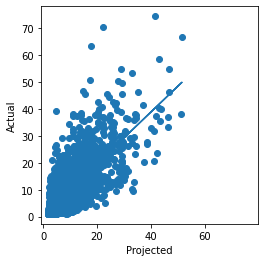

In [507]:
import matplotlib.pyplot as plt


y_test2 = y_test[y_test['num_matchups'] > 0]
# y_test2 = y_test2[y_test2['1B'] == 1]

act = y_test2['%Drafted']
proj = y_test2['ownership_hat']

fig = plt.figure()
ax = fig.add_subplot()

plt.xlabel("Projected")
plt.ylabel("Actual")

a, b = np.polyfit(proj, act, 1)


plt.scatter(proj, act)
plt.plot(proj, a*proj+b)  

# square plot
plt.axis('square')

# plt.show()

In [508]:
y_test2[y_test2['%Drafted'] > 40].query('ownership_hat <20')

,Position,Name,Roster Position,Game Info,TeamAbbrev,Salary,Player,%Drafted,FPTS,away_runs,...,own_rank,own_pct,own_1,own_3,own_5,rs_pct,ra_pct,coors,ownership_hat,difsq
12661,SS,Oswaldo Cabrera,OF/SS,NYY@OAK,NYY,2100,Oswaldo Cabrera,63.40,2.0,4.8,...,1.0,1.0,1.000000,0.750000,0.750000,0.750000,0.250000,0,17.857500,2074.119306
13088,LF,Chris Taylor,2B/OF,SDP@LAD,LAD,3300,Chris Taylor,50.78,10.0,3.4,...,1.0,1.0,0.166667,0.372619,0.414565,0.750000,0.000000,0,17.472567,1109.385115
13089,LF,Trayce Thompson,OF,SDP@LAD,LAD,2500,Trayce Thompson,45.62,2.0,3.4,...,2.0,0.5,0.111111,0.157937,0.236571,0.750000,0.000000,0,15.588067,901.917020
14110,C,Austin Barnes,C,ARI@LAD,LAD,2600,Austin Barnes,46.58,2.0,3.1,...,1.0,1.0,0.166667,0.234127,0.231012,0.833333,0.083333,0,14.708333,1015.803136
